<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Projeto_final/Evaluating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tpot

     |████████████████████████████████| 87 kB 3.4 MB/s 
     |████████████████████████████████| 166.7 MB 10 kB/s 
     |████████████████████████████████| 160 kB 55.7 MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11952 sha256=08bb82e5d1ebd3c82c8545aac99c5de7787b4a10e91e299f088ce0d8a3c3d7e5
  Stored in directory: /root/.cache/pip/wheels/e2/d2/79/eaf81edb391e27c87f51b8ef901ecc85a5363dc96b8b8d71e3
Successfully built stopit
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [343]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline

from tpot.builtins import StackingEstimator
from tpot.builtins import ZeroCount
from tpot.export_utils import set_param_recursive

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif, SelectFwe

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve

import warnings

In [341]:
def multi_score_cv(model, x, y, cv, model_title, set_context = "talk", figsize = (10, 6)):
  with warnings.catch_warnings():
    warnings.simplefilter('ignore') # ignora warnings durante cross_validate
    cv_results = cross_validate(model, x, y, 
                                cv = cv, scoring = ["precision", "roc_auc", "recall", "f1"]) # performa cross validate com parametros escolhidos e separa os scorings de itneresse
  
  precision = cv_results["test_precision"] 
  roc_auc = cv_results["test_roc_auc"]
  recall = cv_results["test_recall"]
  f1 = cv_results["test_f1"]
  scores = pd.DataFrame(dict(Precision = precision, ROC_AUC = roc_auc, Recall = recall, F1 = f1))
  scores_melt = scores.melt()

  plt.figure(figsize = figsize)
  sns.set_context(set_context)
  sns.boxplot(data = scores_melt, x = "value", y = "variable", linewidth = 2.5)
  plt.title(f"Distribuição de valores de score - Modelo: {model_title}")
  plt.xlabel("")
  plt.xlim(-0.1, 1.1)
  plt.ylabel("Métrica")
  plt.show()
  sns.reset_orig()

  return scores

In [4]:
path = "https://raw.githubusercontent.com/RPGraciotti/BootCampAlura/main/Data/data_clean_ohe.csv"

In [5]:
df_clean = pd.read_csv(path)
# df_clean

AVALIAÇÃO DOS MODELOS

MODELO 1 - MAXIMIZAÇÃO DO ROC

In [133]:
m1 = make_pipeline(
    SelectPercentile(score_func=f_classif, percentile=60),
    RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.1, min_samples_leaf=18, min_samples_split=9, n_estimators=100)
)

In [145]:
df_clean = df_clean.sample(frac = 1).reset_index(drop = True)
y = df_clean.loc[:,"ICU"]
y = y.rename("target")
x = df_clean.drop(["PATIENT_VISIT_IDENTIFIER", "ICU", "WINDOW"], axis = 1)

In [146]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2)

In [147]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)

In [148]:
m1_eval = m1.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [21] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


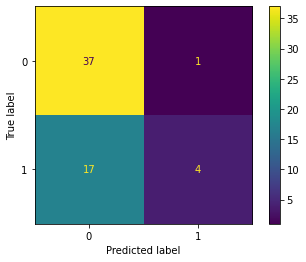

In [149]:
plot_confusion_matrix(m1_eval, x_test, y_test)

In [130]:
print(classification_report(y_test, m1_eval.predict(x_test)))

              precision    recall  f1-score   support

           0       0.86      0.66      0.75        38
           1       0.57      0.81      0.67        21

    accuracy                           0.71        59
   macro avg       0.71      0.73      0.71        59
weighted avg       0.76      0.71      0.72        59



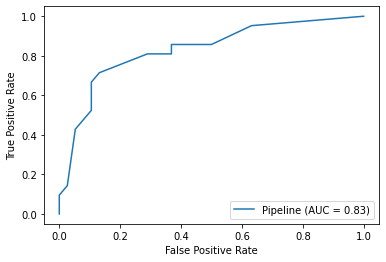

In [131]:
plot_roc_curve(m1_eval, x_test, y_test)
plt.show()

In [132]:
roc_auc_score(y_test, m1_eval.predict_proba(x_test)[:,1])

0.8295739348370927

RECALL

In [321]:
m2 = make_pipeline(
    StackingEstimator(estimator=RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.7500000000000001, 
                                                       min_samples_leaf=2, min_samples_split=14, n_estimators=100, 
                                                       random_state = 78329)),
    StandardScaler(),
    BernoulliNB(alpha=0.01, fit_prior=False)
)

In [322]:
df_clean = df_clean.sample(frac = 1).reset_index(drop = True)
y = df_clean.loc[:,"ICU"]
y = y.rename("target")
x = df_clean.drop(["PATIENT_VISIT_IDENTIFIER", "ICU", "WINDOW"], axis = 1)

In [323]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2)

In [324]:
m2_eval = m2.fit(x_train, y_train)

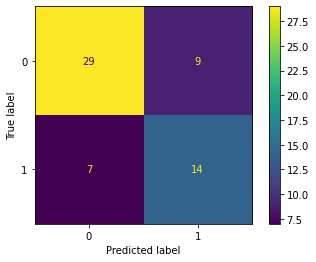

In [325]:
plot_confusion_matrix(m2_eval, x_test, y_test)

In [327]:
print(classification_report(y_test, m2_eval.predict(x_test)))

              precision    recall  f1-score   support

           0       0.81      0.76      0.78        38
           1       0.61      0.67      0.64        21

    accuracy                           0.73        59
   macro avg       0.71      0.71      0.71        59
weighted avg       0.74      0.73      0.73        59



In [ ]:
from sklearn import metrics

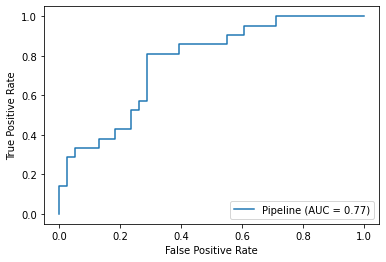

In [ ]:
metrics.plot_roc_curve(model_eval, x_test, y_test)
plt.show()

In [328]:
roc_auc_score(y_test, m2_eval.predict_proba(x_test)[:,1])

0.7556390977443609

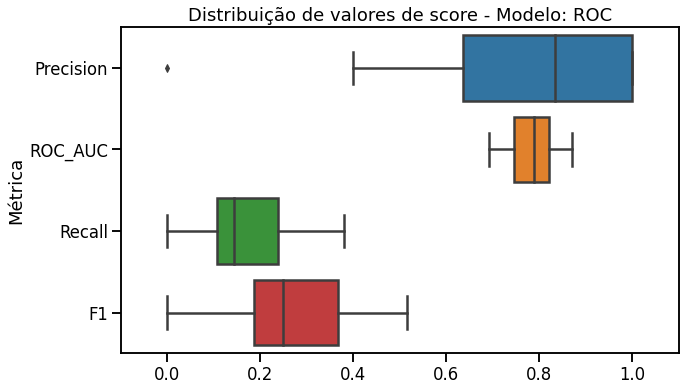

In [339]:
m1_scores = multi_score_cv(model = m1_eval, x = x, y = y, cv = cv, model_title = "ROC")

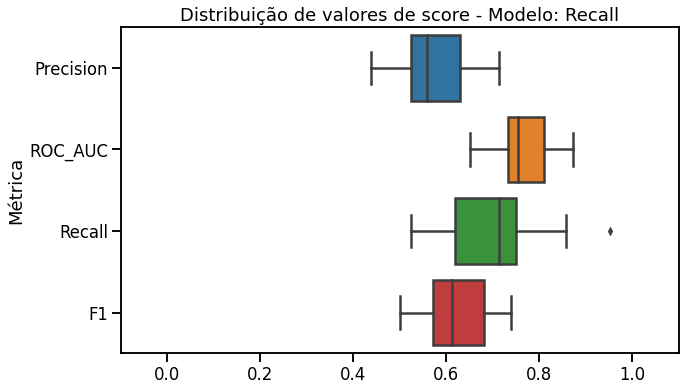

In [340]:
m2_scores = multi_score_cv(model = m2_eval, x = x, y = y, cv = cv, model_title = "Recall")

F1

In [344]:
m3 = make_pipeline(
    ZeroCount(),
    RandomForestClassifier(bootstrap=True, criterion="gini", 
                           max_features=0.7500000000000001, min_samples_leaf=15, min_samples_split=13, n_estimators=100)
)

In [345]:
df_clean = df_clean.sample(frac = 1).reset_index(drop = True)
y = df_clean.loc[:,"ICU"]
y = y.rename("target")
x = df_clean.drop(["PATIENT_VISIT_IDENTIFIER", "ICU", "WINDOW"], axis = 1)

In [346]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2)

In [347]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)

In [348]:
m3_eval = m3.fit(x_train, y_train)

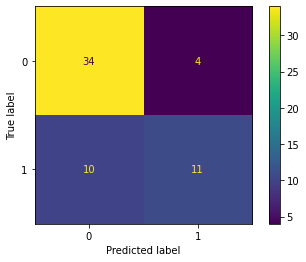

In [349]:
plot_confusion_matrix(m3_eval, x_test, y_test)

In [350]:
print(classification_report(y_test, m3_eval.predict(x_test)))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83        38
           1       0.73      0.52      0.61        21

    accuracy                           0.76        59
   macro avg       0.75      0.71      0.72        59
weighted avg       0.76      0.76      0.75        59



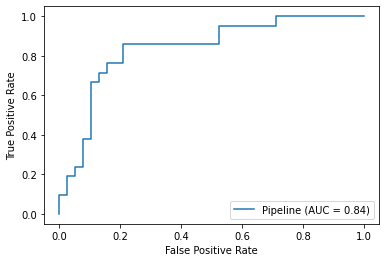

In [351]:
plot_roc_curve(m3_eval, x_test, y_test)
plt.show()

In [352]:
roc_auc_score(y_test, m3_eval.predict_proba(x_test)[:,1])

0.8358395989974937

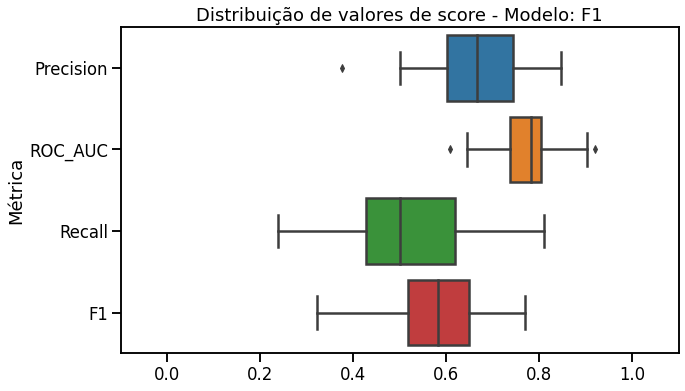

In [353]:
m3_scores = multi_score_cv(model = m3_eval, x = x, y = y, cv = cv,
                           model_title = "F1")

PRECISION

In [354]:
m4 = RandomForestClassifier(bootstrap=True, criterion="gini", 
                            max_features=0.1, min_samples_leaf=15, min_samples_split=9, n_estimators=100)

In [355]:
df_clean = df_clean.sample(frac = 1).reset_index(drop = True)
y = df_clean.loc[:,"ICU"]
y = y.rename("target")
x = df_clean.drop(["PATIENT_VISIT_IDENTIFIER", "ICU", "WINDOW"], axis = 1)

In [356]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify = y, test_size = 0.2)

In [357]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 10)

In [358]:
m4_eval = m4.fit(x_train, y_train)

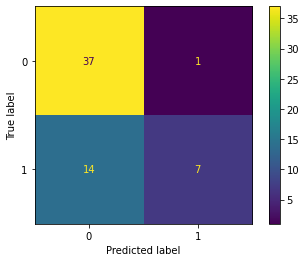

In [364]:
plot_confusion_matrix(m4_eval, x_test, y_test)

In [360]:
print(classification_report(y_test, m4_eval.predict(x_test)))

              precision    recall  f1-score   support

           0       0.73      0.97      0.83        38
           1       0.88      0.33      0.48        21

    accuracy                           0.75        59
   macro avg       0.80      0.65      0.66        59
weighted avg       0.78      0.75      0.71        59



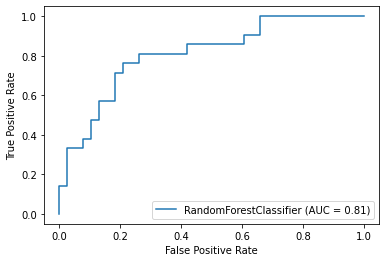

In [361]:
plot_roc_curve(m4_eval, x_test, y_test)
plt.show()

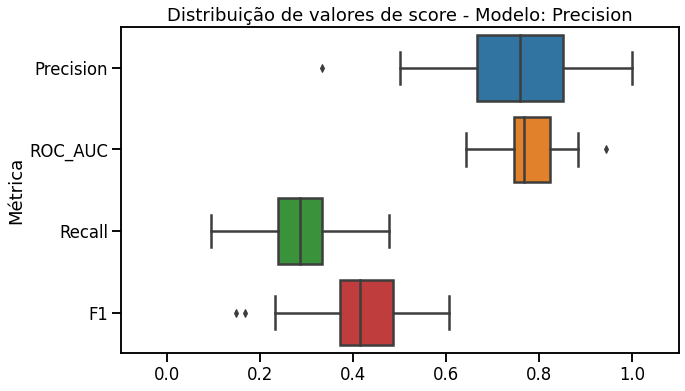

In [363]:
m4_scores = multi_score_cv(model = m4_eval, x = x, y = y, cv = cv,
                           model_title = "Precision")

Definindo plots de confusion matrix

In [ ]:
def roda_modelo_cv(modelo, dados, n_splits, n_repeats):

    d = dados.sample(frac = 1).reset_index(drop = True) # embaralha
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU","WINDOW"], axis=1)

    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats)
    resultados = cross_validate(modelo, x, y, cv = cv, scoring = "roc_auc")

    auc_medio = np.mean(resultados["test_score"])
    auc_std = np.std(resultados["test_score"])

    print(f"AUC Médio {auc_medio}") 
    print(f"Intervalo {auc_medio - (2 * auc_std)} - {auc_medio + (2 * auc_std)}")

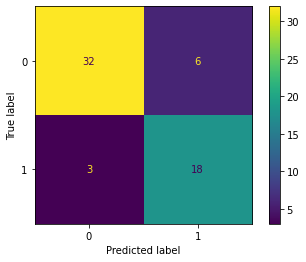

In [365]:
plot_confusion_matrix(m2_eval, x_test, y_test)